# Web Scraping and Introductory Data Analysis

Welcome to Homework 0, where we will delve into web scraping and perform an introductory data analysis. This homework will be a hands-on exercise that will help you become familiar with the process of extracting data from websites and conducting basic statistical analysis. 

## Objectives

By the end of this homework, you will be able to:

1. Set up a Python environment with the necessary libraries for web scraping and data analysis.
2. Write a web scraping script using Beautiful Soup and Selenium to collect data from a website.
3. Sample from the collected dataset and compare the statistics of the sample and the population.
   
## Tasks

1. **Environment Setup**: Install the required libraries such as Beautiful Soup, Selenium, pandas, numpy, matplotlib, and seaborn.

2. **Web Scraping**: Write a script to scrape transaction data from [Etherscan.io](https://etherscan.io/txs). Use Selenium to interact with the website and Beautiful Soup to parse the HTML content.

3. **Data Sampling**: Once the data is collected, create a sample from the dataset. Compare the sample statistics (mean and standard deviation) with the population statistics.


## Deliverables

1. A Jupyter notebook with all the code and explanations.
2. A detailed report on the findings, including the comparison of sample and population statistics.
Note: You can include the report in your notebook.

## Getting Started

Begin by setting up your Python environment and installing the necessary libraries. Then, proceed with the web scraping task, ensuring that you handle any potential issues such as rate limiting. Once you have the data, move on to the data sampling and statistical analysis tasks. 

Remember to document your process and findings in the Jupyter notebook, and to include visualizations where appropriate to illustrate your results. <br>
Good luck, and happy scraping!

## Data Collection (Etherscan)

In this section, we will use web scraping to gather transaction data from the Ethereum blockchain using the Etherscan block explorer. Our objective is to collect transactions from the **last 10 blocks** on Ethereum.

To accomplish this task, we will employ web scraping techniques to extract the transaction data from the Etherscan website. The URL we will be targeting for our data collection is:

[https://etherscan.io/txs](https://etherscan.io/txs)

### Steps

1. **Navigate to the URL**: Use Selenium to open the Etherscan transactions page in a browser.

2. **Locate the Transaction Data**: Identify the HTML elements that contain the transaction data for the specified block range.

3. **Extract the Data**: Write a script to extract the transaction details e.g. Hash, Method, Block, etc.

4. **Handle Pagination**: If the transactions span multiple pages, implement pagination handling to navigate through the pages and collect all relevant transaction data.

5. **Store the Data**: Save the extracted transaction data into a structured format, such as a CSV file or a pandas DataFrame, for further analysis.

### Considerations

- **Rate Limiting**: Be mindful of the website's rate limits to avoid being blocked. Implement delays between requests if necessary.
- **Dynamic Content**: The Etherscan website may load content dynamically. Ensure that Selenium waits for the necessary elements to load before attempting to scrape the data.
- **Data Cleaning**: After extraction, clean the data to remove any inconsistencies or errors that may have occurred during the scraping process.

### Resources

- [Beautiful Soup Documentation](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
- [Selenium Documentation](https://selenium-python.readthedocs.io/)
- [Pandas Documentation](https://pandas.pydata.org/docs/)
- [Ethereum](https://ethereum.org/en/)

# A1
Written by Babak Hosseini Mohtasham 810101408, Mahdy Naeini 810101536 and Parsa Ahmadi 810101609

scraping etherscan and analyzing the data.

## Our code

First we make a new csv file which will be used for storing the data later, then we get the number of last 10 blocks and finally we extract the data for each block. After testing we found out there is no need for waiting for the data to be loaded nor is there any need for limiting the requests rate, so we commented the sleeps. We extract two set of data one is the recent 10 blocks and the other is 10 random blocks from all the existing blocks on the website. Some blocks have no data so we if any exception is raised we skip the block.
While scraping we found out there some transactions have warnings or errors so we added two more coloumns called Warning and Danger. Different transaction failures can be found here:
https://info.etherscan.com/reason-for-failed-transaction/

**Importing necessary libraries**

In [4]:
from bs4 import BeautifulSoup as bs
from selenium import webdriver
from time import sleep
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import scipy.stats as stats
import numpy as np
import seaborn as sns

**Making a new CSV file for storing the data**

In [76]:
def make_new_csv(file_addr):
    with open(file_addr, mode='w') as transactions_file:
        transactionCSV = csv.writer(transactions_file)
        transactionCSV.writerow(
            ['Transaction Hash', 'Method', 'Block Number', 'Age', 'From', 'To', 'Value', 'Txn Fee', 'Warning', 'Danger'])

**Writing data to the CSV file**

In [77]:
def write_to_csv(transactionList, file_addr):
    with open(file_addr, mode='a', encoding='utf-8') as transactions_file:
        transactionCSV=csv.writer(transactions_file)
        for transaction in transactionList:
            tds=transaction.find_all('td')
            transaction_hash=tds[1].text[4:-4]
            method = tds[2].text
            block_number = tds[3].text
            age = tds[5].text
            transaction_from = tds[7].text[4:-5]
            transaction_to = tds[9].text[4:-7]
            value = tds[10].text[:-4]
            txn_fee = tds[11].text
            warning = pd.NA
            if tds[1].find('span', {'class': 'text-warning'}) is not None:
                warning = tds[1].find(
                    'span', {'class': 'text-warning'}).get("data-bs-title")
            danger = pd.NA
            if tds[1].find('span', {'class': 'text-danger'}) is not None:
                danger = tds[1].find(
                    'span', {'class': 'text-danger'}).get("data-bs-title")
            transactionCSV.writerow([transaction_hash, method,block_number,age,transaction_from,transaction_to,value,txn_fee,warning,danger])

**Scraping data from a specific block**

In [78]:
class BlockNotFound(Exception):
    pass

In [79]:
def scrape_block_data(block_number, driver, file_addr):
    driver.get(f'https://etherscan.io/txs?block={block_number}')
    sleep(0.1)
    page = driver.page_source
    soup = bs(page, 'html.parser')
    pagination = soup.find_all(
        'ul', {'class': 'pagination pagination-sm mb-0'})
    if not pagination:
        raise BlockNotFound()
    number_of_pages = int(pagination[0].find_all('li')[-3].text.split()[-1])
    for p in range(number_of_pages):
        driver.get(
            f'https://etherscan.io/txs?block={block_number}&p={p+1}')
        sleep(0.1)
        page = driver.page_source
        soup = bs(page, 'html.parser')
        content = soup.find('tbody', {'class': 'align-middle text-nowrap'})
        transactionList = content.find_all('tr')
        write_to_csv(transactionList, file_addr)

**Scraping the recent blocks**

In [80]:
def scrape_recent_transactions(number_of_blocks, file_addr):
    make_new_csv(file_addr)
    driver = webdriver.Chrome()
    driver.get(f'https://etherscan.io/blocks')
    sleep(0.1)
    page = driver.page_source
    soup = bs(page, 'html.parser')
    blocks = soup.find('tbody', {'class': 'align-middle text-nowrap'})
    last_block = int(blocks.find_all('td')[0].text)
    cnt_of_extracted_blocks=0
    i=0
    while cnt_of_extracted_blocks<number_of_blocks:
        try:
            scrape_block_data(last_block-i, driver, file_addr)
            i+=1
        except BlockNotFound:
            continue
        cnt_of_extracted_blocks+=1
    driver.close()

**Scraping random blocks**

In [81]:
def scrape_random_transactions(number_of_blocks, file_addr):
    make_new_csv(file_addr)
    driver = webdriver.Chrome()
    driver.get(f'https://etherscan.io/blocks')
    sleep(0.1)
    page = driver.page_source
    soup = bs(page, 'html.parser')
    blocks = soup.find('tbody', {'class': 'align-middle text-nowrap'})
    last_block = int(blocks.find_all('td')[0].text)
    extracted_blocks=set()
    cnt_of_extracted_blocks=0
    while cnt_of_extracted_blocks < number_of_blocks:
        try:
            block = random.randint(0, last_block)
            if block in extracted_blocks:
                continue
            extracted_blocks.add(block)
            scrape_block_data(block, driver, file_addr)
        except BlockNotFound:
            continue
        cnt_of_extracted_blocks+=1
    driver.close()

In [83]:
scrape_recent_transactions(10,"recent_transactions.csv")
scrape_random_transactions(10,"random_transactions.csv")

## Data Analysis

Now that we have collected the transaction data from Etherscan, the next step is to perform conduct an initial analysis. This task will involve the following steps:

1. **Load the Data**: Import the collected transaction data into a pandas DataFrame.

2. **Data Cleaning**: Clean the data by converting data types, removing any irrelevant information, and handling **duplicate** values.

3. **Statistical Analysis**: Calculate the mean and standard deviation of the population. Evaluate these statistics to understand the distribution of transaction values. The analysis and plotting will be on **Txn Fee** and **Value**.

4. **Visualization**: This phase involves the creation of visual representations to aid in the analysis of transaction values. The visualizations include:
    - A histogram for each data column, which provides a visual representation of the data distribution. The selection of bin size is crucial and should be based on the data's characteristics to ensure accurate representation. Provide an explanation on the bin size selection!
    - A normal distribution plot fitted alongside the histogram to compare the empirical distribution of the data with the theoretical normal distribution.
    - A box plot and a violin plot to identify outliers and provide a comprehensive view of the data's distribution.

### Deliverables

The project aims to deliver the following deliverables:

- A refined pandas DataFrame containing the transaction data, which has undergone thorough cleaning and is ready for analysis.
- A simple statistical analysis evaluating the population statistics, offering insights into the distribution of transaction values and fees.
- A set of visualizations showcasing the distribution of transaction values for the population. These visualizations include histograms, normal distribution plots, box plots, and violin plots, each serving a specific purpose in the analysis.

### Getting Started

The project starts with the importing of transaction data into a pandas DataFrame, setting the stage for data manipulation and analysis. Subsequent steps involve the cleaning of the data to ensure its quality and reliability. Followed by the calculation of population statistics. Finally, a series of visualizations are created to visually analyze the distribution of transaction values and fees.

## Load Recent blocks and cleaning:

After analyzing the data we around half the transactions were zero-valued transactions. After googling we found this article that explains Zero-Value Token Transfer Attack so we decided to remove the rows with zero transaction as the purpose of those transactions is different from the other transactions.

https://info.etherscan.com/zero-value-token-transfer-attack/#:~:text=Be%20cautious%20when%20interacting%20with,you%20intend%20to%20interact%20with.

In [15]:
# load data
recent_blocks_df = pd.read_csv('recent_transactions.csv')

recent_blocks_cnt = len(recent_blocks_df)

print(f'Number of rows: {recent_blocks_cnt}')
print(f"Number of rows with warning: {recent_blocks_df['Warning'].count()}")
print(f"{recent_blocks_df['Warning'].value_counts()}")
print(f"Number of rows with danger: {recent_blocks_df['Danger'].count()}")
print(f"{recent_blocks_df['Danger'].value_counts()}")

# Convert 'Value' and 'Txn Fee' to numeric, forcing non-numeric values to NaN
recent_blocks_df['Value'] = pd.to_numeric(recent_blocks_df['Value'], errors='coerce')
recent_blocks_df['Txn Fee'] = pd.to_numeric(recent_blocks_df['Txn Fee'], errors='coerce')

# Drop rows with NaN in specific columns if conversion resulted in NaN values
number_of_rows=len(recent_blocks_df)
recent_blocks_df.dropna(subset=['Value', 'Txn Fee'], inplace=True)
print(f"Number of rows with NaN in Value and Txn Fee columns:\n{number_of_rows-len(recent_blocks_df)}")

# Adding a new column for the sum of 'Value' and 'Txn Fee'
recent_blocks_df['Total'] = recent_blocks_df['Value'] + np.multiply(recent_blocks_df['Txn Fee'],recent_blocks_df['Value'])

# Drop duplicates
number_of_rows=len(recent_blocks_df)
recent_blocks_df.drop_duplicates(subset=["Transaction Hash", 'Method', 'Block Number', 'From', 'To', 'Value', 'Txn Fee'], keep="first", inplace=True)
print(f'Number of duplicates: {number_of_rows-len(recent_blocks_df)}')

# Filtering transactions based on 'Value' and 'Txn Fee' ranges
number_of_rows=len(recent_blocks_df)
recent_blocks_df = recent_blocks_df[(recent_blocks_df['Value'] > 0)]
recent_blocks_zero_values_cnt = number_of_rows-len(recent_blocks_df)
print(f'Number of transactions with value of 0: {recent_blocks_zero_values_cnt}')

recent_warning_df = recent_blocks_df.dropna(subset=['Warning'], inplace=False)
recent_danger_df = recent_blocks_df.dropna(subset=['Danger'], inplace=False)

Number of rows: 1734
Number of rows with warning: 2
Warning
Error in Internal Txn : execution reverted    2
Name: count, dtype: int64
Number of rows with danger: 36
Danger
Error in Main Txn : execution reverted         35
Error in Main Txn : invalid opcode: INVALID     1
Name: count, dtype: int64
Number of rows with NaN in Value and Txn Fee columns:
0
Number of duplicates: 0
Number of transactions with value of 0: 870


## Load Random blocks and cleaning:

In [16]:
# load data
random_blocks_df = pd.read_csv('random_transactions.csv')

random_blocks_cnt = len(random_blocks_df)

print(f'Number of rows: {random_blocks_cnt}')
print(f"Number of rows with warning: {random_blocks_df['Warning'].count()}")
print(f"{random_blocks_df['Warning'].value_counts()}")
print(f"Number of rows with danger: {random_blocks_df['Danger'].count()}")
print(f"{random_blocks_df['Danger'].value_counts()}")


# Convert 'Value' and 'Txn Fee' to numeric, forcing non-numeric values to NaN
random_blocks_df['Value'] = pd.to_numeric(
    random_blocks_df['Value'], errors='coerce')
random_blocks_df['Txn Fee'] = pd.to_numeric(
    random_blocks_df['Txn Fee'], errors='coerce')

# Drop rows with NaN in specific columns if conversion resulted in NaN values
number_of_rows = len(recent_blocks_df)
random_blocks_df.dropna(subset=['Value', 'Txn Fee'], inplace=True)
print(f"Number of rows with NaN in Value and Txn Fee columns:\n{number_of_rows-len(random_blocks_df)}")

# Adding a new column for the sum of 'Value' and 'Txn Fee'
random_blocks_df['Total'] = random_blocks_df['Value'] + \
    np.multiply(random_blocks_df['Txn Fee'], random_blocks_df['Value'])

# Drop duplicates
number_of_rows = len(random_blocks_df)
random_blocks_df.drop_duplicates(
    subset=["Transaction Hash", 'Method', 'Block Number', 'From', 'To', 'Value', 'Txn Fee'], keep="first", inplace=True)
print(f'Number of duplicates: {number_of_rows-len(random_blocks_df)}')

# Filtering transactions based on 'Value' and 'Txn Fee' ranges
number_of_rows = len(random_blocks_df)
random_blocks_df = random_blocks_df[(random_blocks_df['Value'] > 0)]
random_blocks_zero_values_cnt = number_of_rows-len(random_blocks_df)
print(f'Number of transactions with value of 0: {random_blocks_zero_values_cnt}')

random_warning_df = pd.concat([random_blocks_df.dropna(
    subset=['Warning'], inplace=False), recent_warning_df])
random_danger_df = pd.concat([random_blocks_df.dropna(subset=['Danger'], inplace=False), recent_danger_df])

Number of rows: 1711
Number of rows with warning: 1
Warning
Error in Internal Txn : Reverted    1
Name: count, dtype: int64
Number of rows with danger: 31
Danger
Error in Main Txn : Reverted              18
Error in Main Txn : Out of gas            11
Error in Main Txn : execution reverted     2
Name: count, dtype: int64
Number of rows with NaN in Value and Txn Fee columns:
-845
Number of duplicates: 0
Number of transactions with value of 0: 661


## Statistical Analysis on Recent blocks:

value: 
mean= 2.8604
std= 19.0614
Txn Fee: 
mean= 0.0054
std= 0.0094
Total: 
mean= 2.8785
std= 19.1836


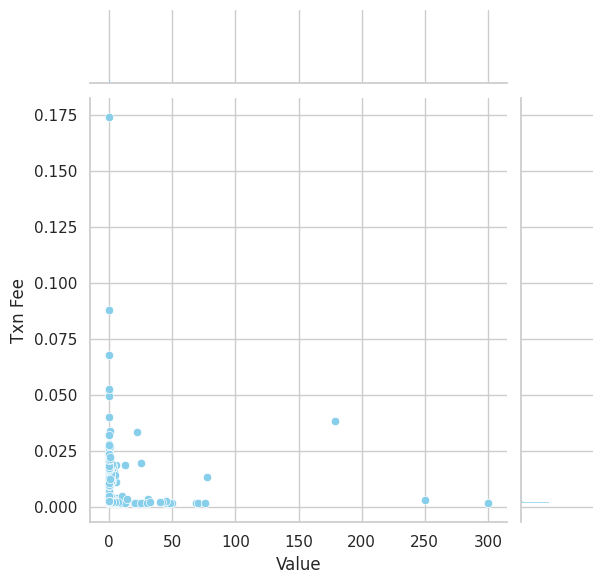

In [17]:
# mean and std
mean_value = recent_blocks_df['Value'].mean()
std_value = recent_blocks_df['Value'].std()
mean_txn_fee = recent_blocks_df['Txn Fee'].mean()
std_txn_fee = recent_blocks_df['Txn Fee'].std()
mean_total = recent_blocks_df['Total'].mean()
std_total = recent_blocks_df['Total'].std()

print("value: " )
print(f"mean= {mean_value:.4f}")
print(f"std= {std_value:.4f}")
print("Txn Fee: " )
print(f"mean= {mean_txn_fee:.4f}")
print(f"std= {std_txn_fee:.4f}")
print("Total: " )
print(f"mean= {mean_total:.4f}")
print(f"std= {std_total:.4f}")

sns.set_theme(style="whitegrid")
sns.jointplot(x="Value", y="Txn Fee", data=recent_blocks_df, kind="scatter", color = "skyblue")
plt.show()

## Statistical Analysis on Random blocks

value: 
mean= 6.8896
std= 55.2440
Txn Fee: 
mean= 0.0023
std= 0.0050
Total: 
mean= 6.8950
std= 55.2801


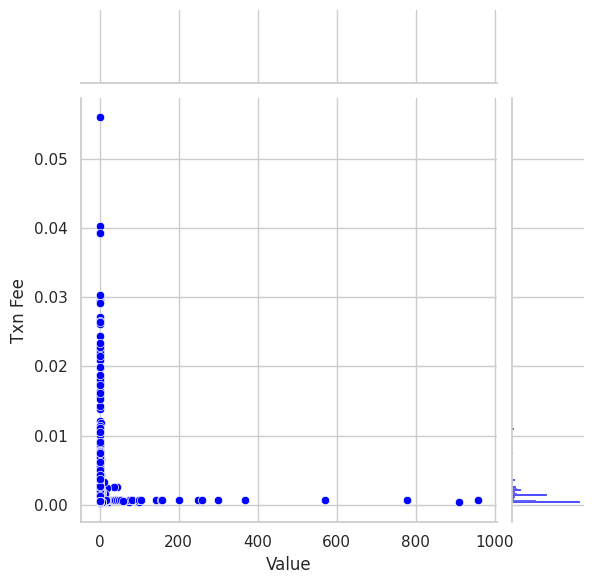

In [18]:
# mean and std
mean_value = random_blocks_df['Value'].mean()
std_value = random_blocks_df['Value'].std()
mean_txn_fee = random_blocks_df['Txn Fee'].mean()
std_txn_fee = random_blocks_df['Txn Fee'].std()
mean_total = random_blocks_df['Total'].mean()
std_total = random_blocks_df['Total'].std()

print("value: " )
print(f"mean= {mean_value:.4f}")
print(f"std= {std_value:.4f}")
print("Txn Fee: " )
print(f"mean= {mean_txn_fee:.4f}")
print(f"std= {std_txn_fee:.4f}")
print("Total: " )
print(f"mean= {mean_total:.4f}")
print(f"std= {std_total:.4f}")

sns.set_theme(style="whitegrid")
sns.jointplot(x="Value", y="Txn Fee", data=random_blocks_df, kind="scatter", color = "blue")
plt.show()

We can see that the fee of neither recent nor random transactions is not proportional to value the reason for which can be found here:
https://ethereum.stackexchange.com/questions/94443/is-ethereum-transaction-fee-supposed-to-be-proportional-to-the-amount-sent#:~:text=No%2C%20the%20fee%20of%20a,of%20the%20transferred%20ETH%20amount.

## Comparing recent blocks with random blocks

In [19]:
recent_and_random_df=pd.concat([recent_blocks_df, random_blocks_df],keys=['recent blocks', 'random blocks'],axis=1)

In [20]:
print(f'ratio of zero values in recent transactiosn: {recent_blocks_zero_values_cnt/recent_blocks_cnt}')
print(f'ratio of zero values in random transactiosn: {random_blocks_zero_values_cnt/random_blocks_cnt}')

ratio of zero values in recent transactiosn: 0.5017301038062284
ratio of zero values in random transactiosn: 0.3863237872589129


We can clearly see that the mean value of recent transactions is more than twice the mean value of random blocks which means the value of transactions using ethereum has increased which may have many reasons including the increase of trust of people and companies using ethereum. Furthermore we can see the ratio of zero values has increased which may be mean the number of ethereum scammers has increased.

In [21]:
recent_and_random_df.describe()

recent blocks                                         random blocks  \
       Block Number         Value     Txn Fee         Total  Block Number   
count  8.640000e+02  8.640000e+02  864.000000  8.640000e+02  1.048000e+03   
mean   1.939141e+07  2.860369e+00    0.005426  2.878505e+00  1.012048e+07   
std    2.754722e+00  1.906142e+01    0.009378  1.918358e+01  4.975876e+06   
min    1.939141e+07  1.000000e-09    0.002022  1.052743e-09  1.626917e+06   
25%    1.939141e+07  2.302774e-02    0.002114  2.307619e-02  6.945150e+06   
50%    1.939141e+07  1.000000e-01    0.002201  1.002344e-01  1.221713e+07   
75%    1.939141e+07  5.000000e-01    0.002886  5.010485e-01  1.287277e+07   
max    1.939142e+07  3.000000e+02    0.173902  3.006425e+02  1.741945e+07   

                                                
              Value      Txn Fee         Total  
count  1.048000e+03  1048.000000  1.048000e+03  
mean   6.889597e+00     0.002316  6.895033e+00  
std    5.524401e+01     0.005016  5.528008e+01  
min    6.000000e-09     0.000252  6.025752e-09  
25%    1.683158e-02     0.000420  1.683865e-02  
50%    5.676797e-02     0.000735  5.683529e-02  
75%    3.604697e-01     0.001664  3.616676e-01  
max    9.589793e+02     0.056012  9.596841e+02

## Visualization

Number of Bins: The choice of the number of bins (between 5 and 20, for example) depends on the size of the data set. A larger dataset may require more bins to accurately represent the data distribution. However, having too many bins can lead to over-smoothing, while too few bins may not capture the nuances of the data distribution effectively.

Even Division of Data: If possible, the data set should be evenly divisible by the number of bins chosen. This ensures that the data is distributed evenly across the bins, leading to a more balanced and representative histogram.

Interpretability: Choosing appropriate bin sizes and boundaries is crucial for the interpretability of the histogram. It allows for a clear understanding of the data distribution, including the presence of peaks, troughs, and any skewness in the data. Inappropriate bin sizes can lead to misleading interpretations of the data.

By plotting with different number of bins we've chosen 30 because we thinks its the right amount to be both visually appropriate and can be more easily interpreted.

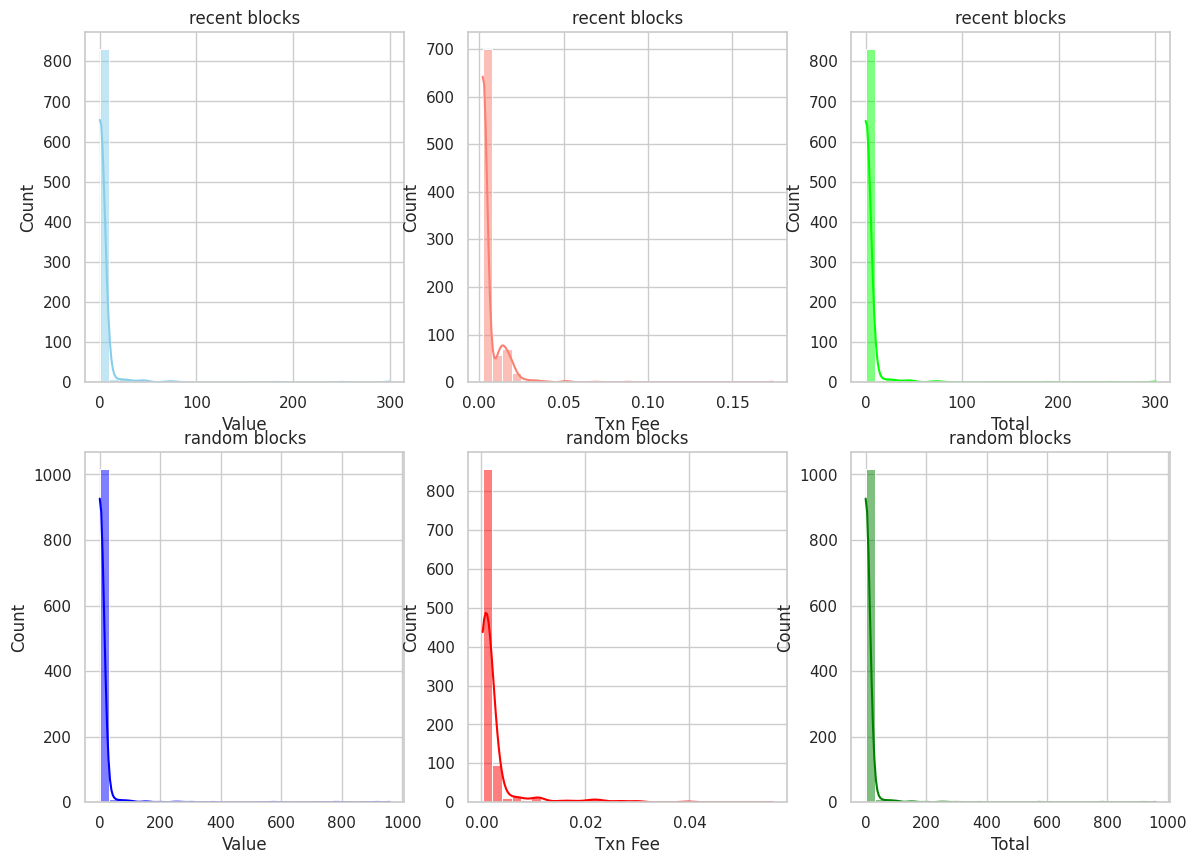

In [22]:
# show hist plot 

sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 10))

datas = [recent_blocks_df, random_blocks_df]
coulmns = ["Value", "Txn Fee", "Total"]
colors = ["skyblue", "salmon", "lime", "blue", "red", "green"]
titles = ["recent blocks","random blocks"]

for i in range(len(colors)):
    plt.subplot(2,3,i+1)
    sns.histplot(datas[i//3][coulmns[i%3]], bins=30, kde=True, color= colors[i])
    plt.title(titles[i//3])

plt.show()

We can see from the Q-Q plot that the sample follow the normal distribution.

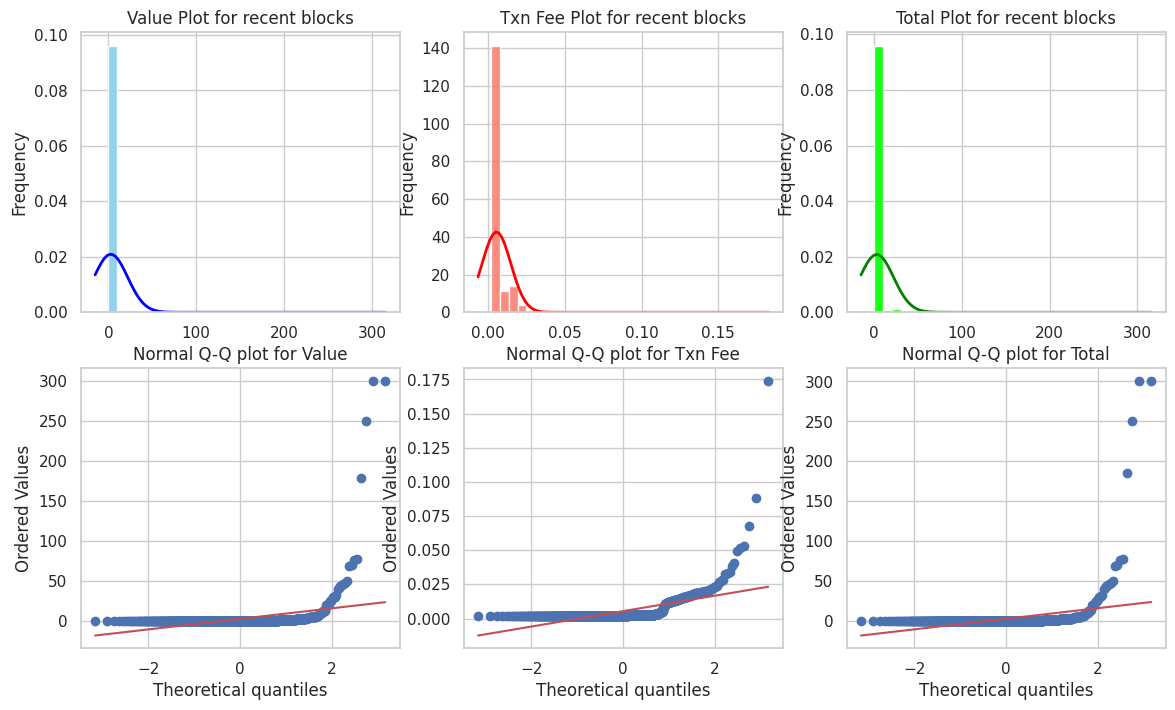

In [23]:
# comparing with normal distribution for recent blocks

sns.set_theme(style="whitegrid")
coulmns = ["Value", "Txn Fee", "Total"]
colors = ["skyblue", "salmon", "lime", "blue", "red", "green"]
plt.figure(figsize=(14, 8))

for i in range(len(coulmns)):
    plt.subplot(2,3,i+1)
    mu, std = stats.norm.fit(recent_blocks_df[coulmns[i]])
    recent_blocks_df[coulmns[i]].plot.hist(bins=30, alpha=0.9, density= True, color = colors[i])
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    plt.plot(x, p, colors[3+i], linewidth=2)
    plt.title(f"{coulmns[i]} Plot for recent blocks")

# Q-Q plot
for i in range(len(coulmns)):
    plt.subplot(2,3,i+4)
    stats.probplot(recent_blocks_df[coulmns[i]], dist="norm", plot=plt)
    plt.title(f"Normal Q-Q plot for {coulmns[i]}")

plt.show()


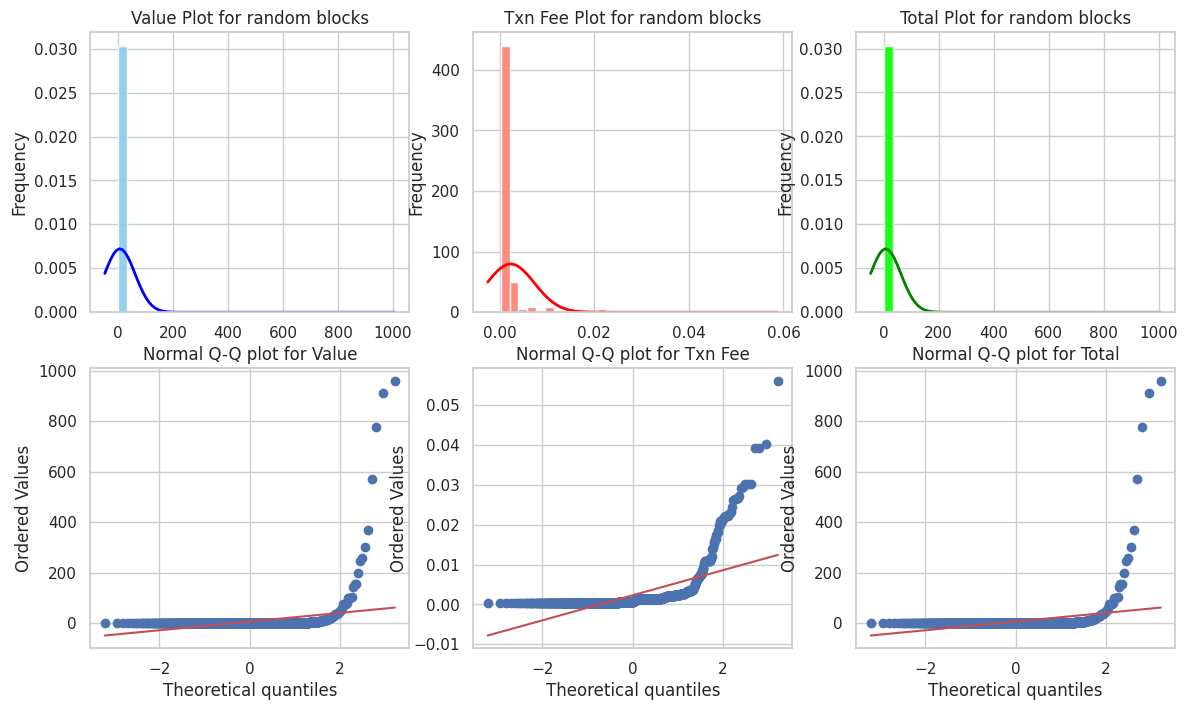

In [24]:
# comparing with normal distribution for random blocks

sns.set_theme(style="whitegrid")
coulmns = ["Value", "Txn Fee", "Total"]
colors = ["skyblue", "salmon", "lime", "blue", "red", "green"]
plt.figure(figsize=(14, 8))

for i in range(len(coulmns)):
    plt.subplot(2,3,i+1)
    mu, std = stats.norm.fit(random_blocks_df[coulmns[i]])
    random_blocks_df[coulmns[i]].plot.hist(bins=30, alpha=0.9, density= True, color = colors[i])
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    plt.plot(x, p, colors[3+i], linewidth=2)
    plt.title(f"{coulmns[i]} Plot for random blocks")

# Q-Q plot
for i in range(len(coulmns)):
    plt.subplot(2,3,i+4)
    stats.probplot(random_blocks_df[coulmns[i]], dist="norm", plot=plt)
    plt.title(f"Normal Q-Q plot for {coulmns[i]}")

plt.show()


After transforming the data using the logarithm function we can clearly see the bell curve in both value and total coloumns.

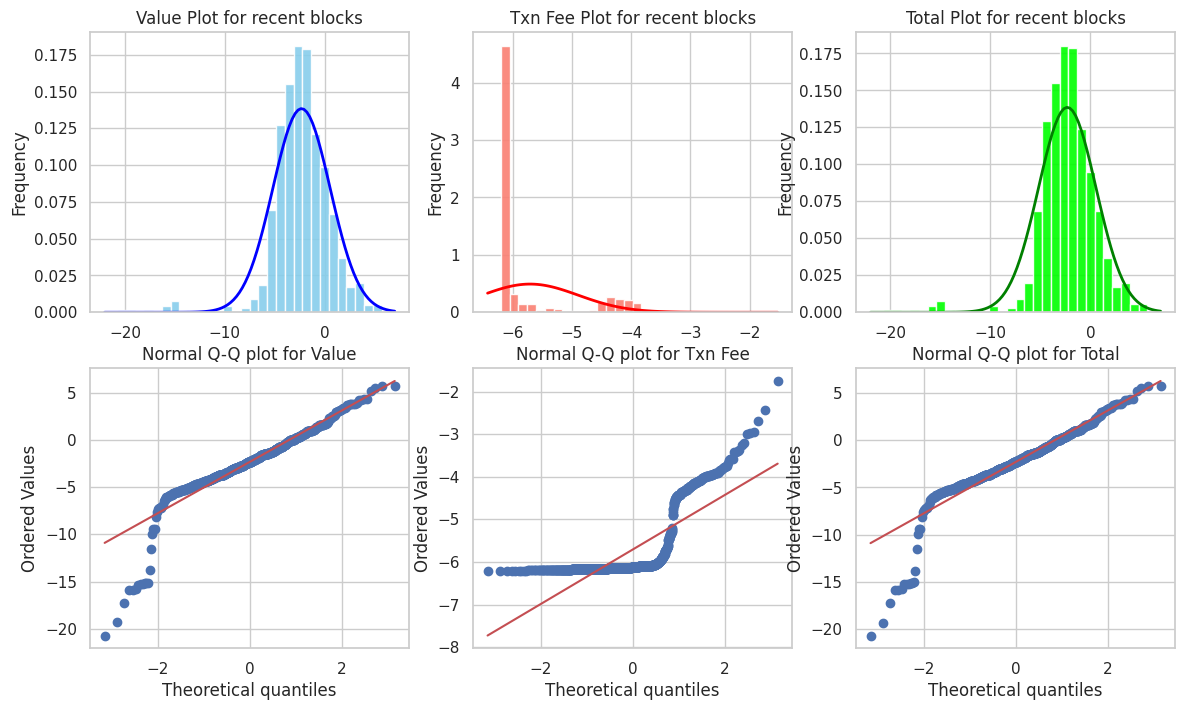

In [25]:
# comparing with log normal distribution for recent blocks

# load data
recent_blocks_df_log = pd.read_csv('recent_transactions.csv')
recent_blocks_df_log['Value'] = pd.to_numeric(recent_blocks_df_log['Value'], errors='coerce')
recent_blocks_df_log['Txn Fee'] = pd.to_numeric(recent_blocks_df_log['Txn Fee'], errors='coerce')
recent_blocks_df.dropna(subset=['Value', 'Txn Fee'], inplace=True)
recent_blocks_df_log = recent_blocks_df_log[((recent_blocks_df_log['Value'] > 0)) & ((recent_blocks_df_log['Txn Fee'] > 0))]
recent_blocks_df_log.drop_duplicates(subset=["Transaction Hash", 'Method', 'Block Number', 'From', 'To', 'Value', 'Txn Fee'], keep="first", inplace=True)
recent_blocks_df_log['Total'] = recent_blocks_df_log['Value'] + np.multiply(recent_blocks_df_log['Txn Fee'],recent_blocks_df_log['Value'])

# get log
recent_blocks_df_log['Value'] = recent_blocks_df_log['Value'].apply(lambda num: math.log(num))
recent_blocks_df_log['Txn Fee'] = recent_blocks_df_log['Txn Fee'].apply(lambda num: math.log(num))
recent_blocks_df_log['Total'] = recent_blocks_df_log['Total'].apply(lambda num: math.log(num))

sns.set_theme(style="whitegrid")
coulmns = ["Value", "Txn Fee", "Total"]
colors = ["skyblue", "salmon", "lime", "blue", "red", "green"]
plt.figure(figsize=(14, 8))

# plots
for i in range(len(coulmns)):
    plt.subplot(2,3,i+1)
    mu, std = stats.norm.fit(recent_blocks_df_log[coulmns[i]])
    recent_blocks_df_log[coulmns[i]].plot.hist(bins=30, color = colors[i] , alpha=0.9 ,density= True)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    plt.plot(x, p, linewidth=2, color = colors[3 + i])
    plt.title(f"{coulmns[i]} Plot for recent blocks")

# Q-Q plot
for i in range(len(coulmns)):
    plt.subplot(2,3,i+4)
    stats.probplot(recent_blocks_df_log[coulmns[i]], dist="norm", plot=plt)
    plt.title(f"Normal Q-Q plot for {coulmns[i]}")


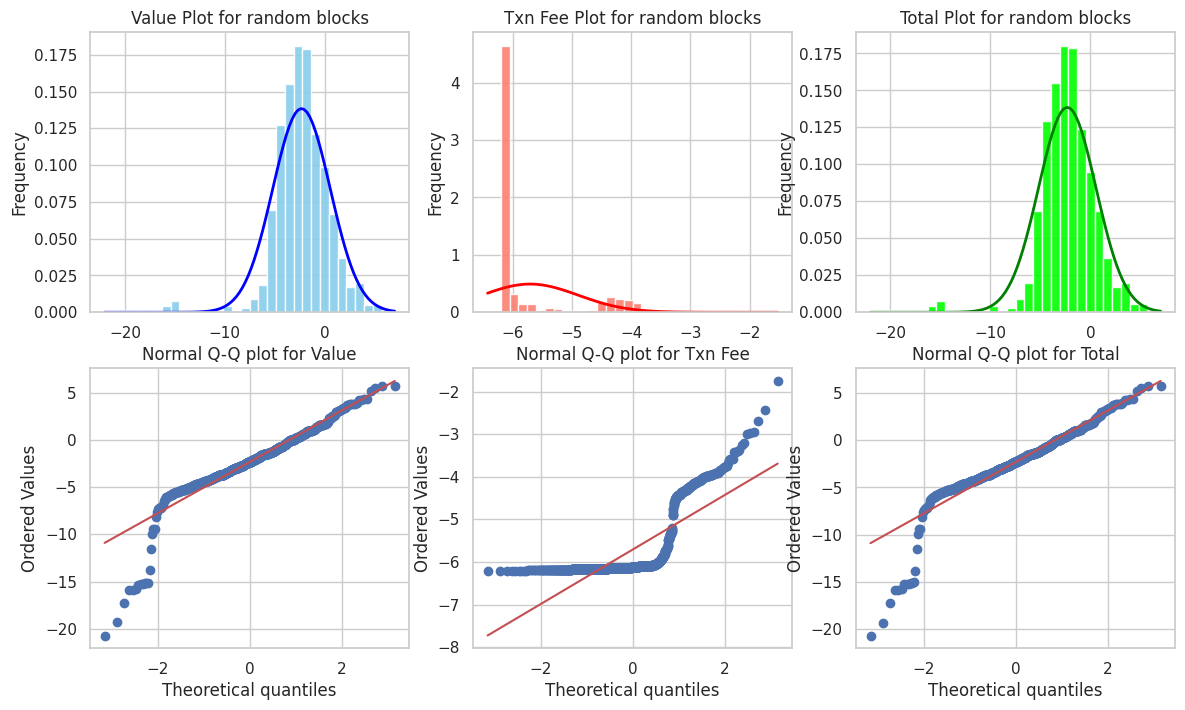

In [26]:
# comparing with log normal distribution for random blocks

# load data
random_blocks_df_log = pd.read_csv('recent_transactions.csv')
random_blocks_df_log['Value'] = pd.to_numeric(random_blocks_df_log['Value'], errors='coerce')
random_blocks_df_log['Txn Fee'] = pd.to_numeric(random_blocks_df_log['Txn Fee'], errors='coerce')
recent_blocks_df.dropna(subset=['Value', 'Txn Fee'], inplace=True)
random_blocks_df_log = random_blocks_df_log[((random_blocks_df_log['Value'] > 0)) & ((random_blocks_df_log['Txn Fee'] > 0))]
random_blocks_df_log.drop_duplicates(subset=["Transaction Hash", 'Method', 'Block Number', 'From', 'To', 'Value', 'Txn Fee'], keep="first", inplace=True)
random_blocks_df_log['Total'] = random_blocks_df_log['Value'] + np.multiply(random_blocks_df_log['Txn Fee'],random_blocks_df_log['Value'])

# get log
random_blocks_df_log['Value'] = random_blocks_df_log['Value'].apply(lambda num: math.log(num))
random_blocks_df_log['Txn Fee'] = random_blocks_df_log['Txn Fee'].apply(lambda num: math.log(num))
random_blocks_df_log['Total'] = random_blocks_df_log['Total'].apply(lambda num: math.log(num))

sns.set_theme(style="whitegrid")
coulmns = ["Value", "Txn Fee", "Total"]
colors = ["skyblue", "salmon", "lime", "blue", "red", "green"]
plt.figure(figsize=(14, 8))

# plots
for i in range(len(coulmns)):
    plt.subplot(2,3,i+1)
    mu, std = stats.norm.fit(random_blocks_df_log[coulmns[i]])
    random_blocks_df_log[coulmns[i]].plot.hist(bins=30, color = colors[i] , alpha=0.9 ,density= True)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    plt.plot(x, p, linewidth=2, color = colors[3 + i])
    plt.title(f"{coulmns[i]} Plot for random blocks")

# Q-Q plot
for i in range(len(coulmns)):
    plt.subplot(2,3,i+4)
    stats.probplot(random_blocks_df_log[coulmns[i]], dist="norm", plot=plt)
    plt.title(f"Normal Q-Q plot for {coulmns[i]}")


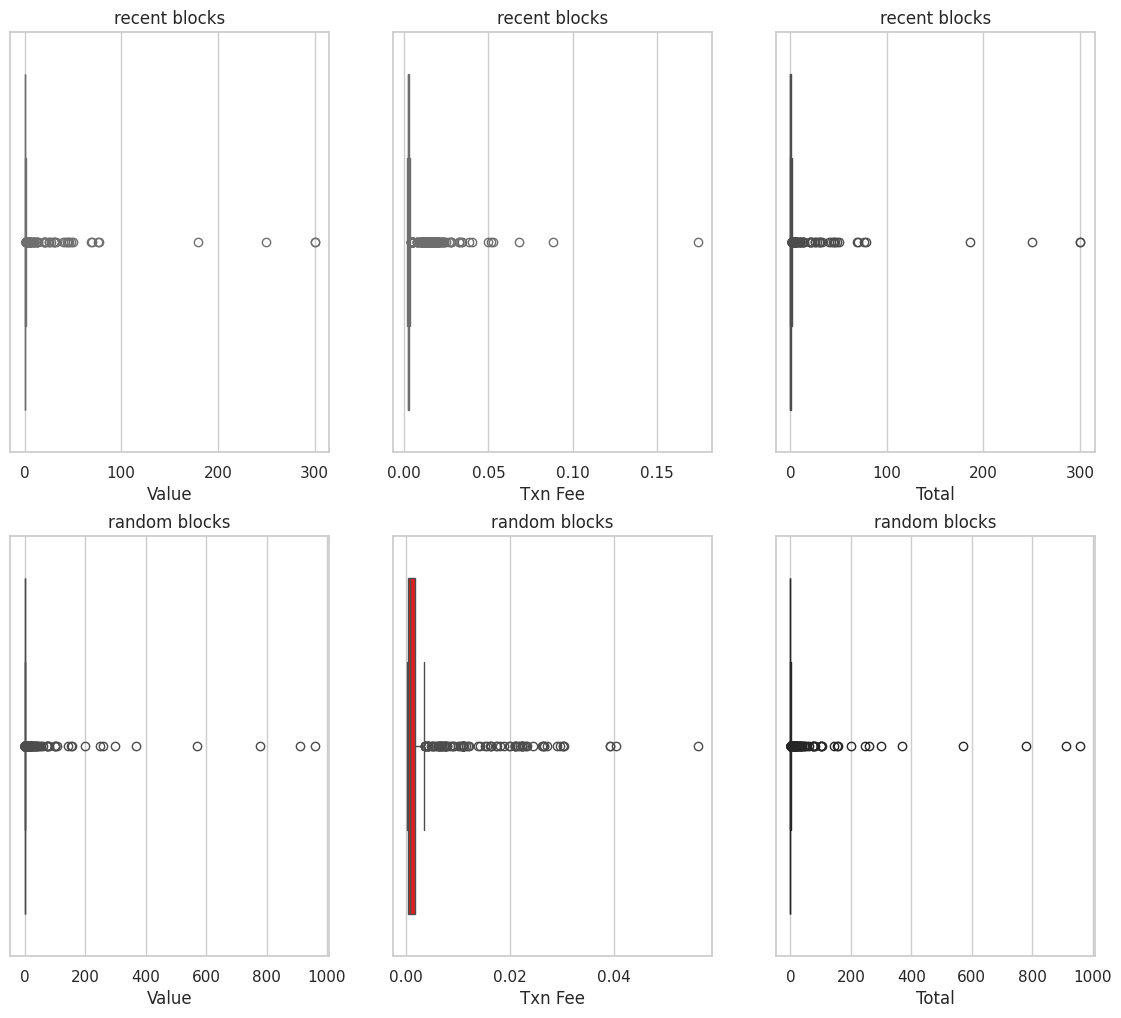

In [27]:
# box plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 12))

datas = [recent_blocks_df, random_blocks_df]
coulmns = ["Value", "Txn Fee", "Total"]
colors = ["skyblue", "salmon", "lime", "blue", "red", "green"]
titles = ["recent blocks","random blocks"]

for i in range(len(colors)):
    plt.subplot(2,3,i+1)
    sns.boxplot(x = datas[i//3][coulmns[i%3]], color= colors[i])
    plt.title(titles[i//3])

plt.show()


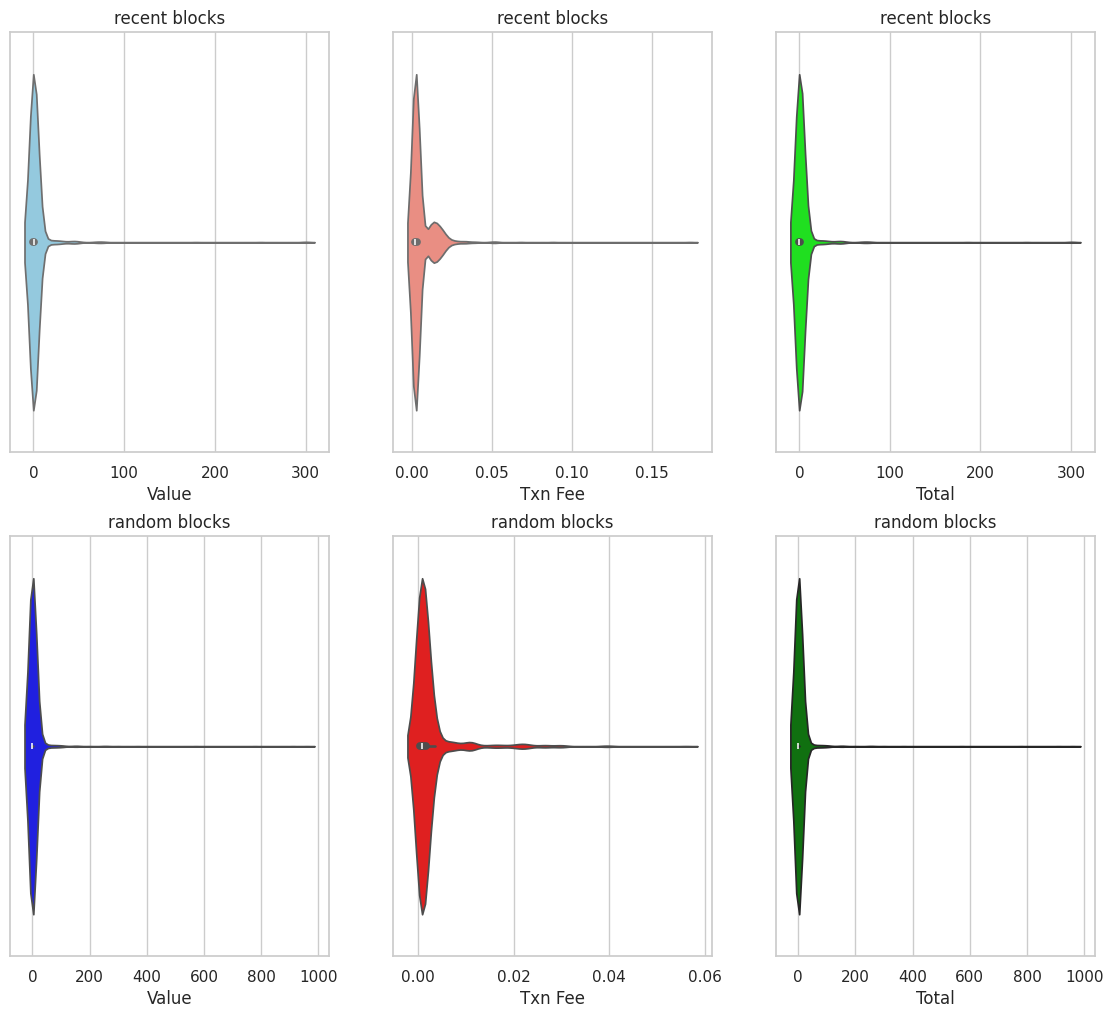

In [28]:
# violin plots
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 12))

datas = [recent_blocks_df, random_blocks_df]
coulmns = ["Value", "Txn Fee", "Total"]
colors = ["skyblue", "salmon", "lime", "blue", "red", "green"]
titles = ["recent blocks","random blocks"]

for i in range(len(colors)):
    plt.subplot(2,3,i+1)
    sns.violinplot(x = datas[i//3][coulmns[i%3]], color= colors[i])
    plt.title(titles[i//3])

plt.show()

Because there are very few transactions with warning we didn't plot a graph for them. Furthermore, for the same reason we've merged the recent and random danger errors to get a population with more enough size.

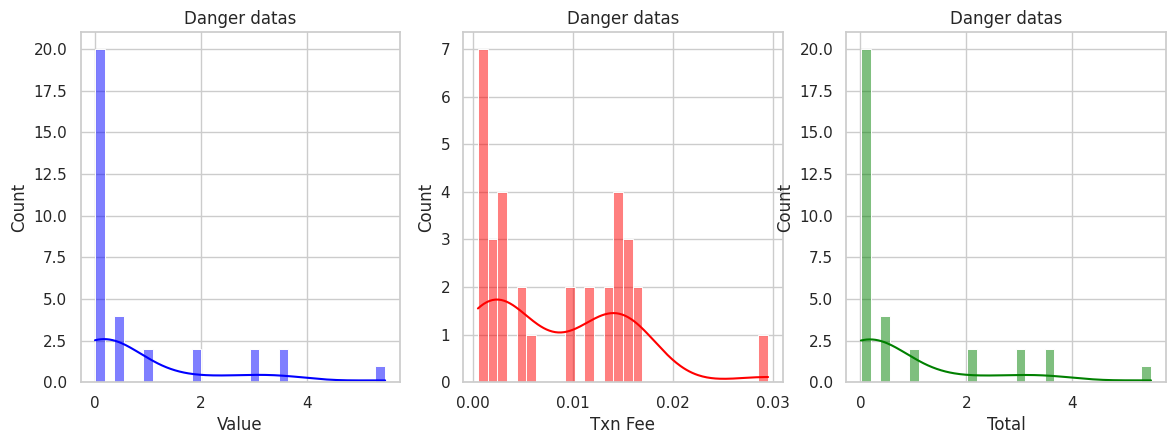

In [29]:
# show hist plot for Danger and Warning datas
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 10))
danger_df=pd.concat([recent_danger_df,random_danger_df])
datas = [danger_df]
coulmns = ["Value", "Txn Fee", "Total"]
colors = ["blue", "red", "green"]
titles = ["Danger datas"]

for i in range(len(colors)):
    plt.subplot(2,3,i+1)
    sns.histplot(datas[i//3][coulmns[i%3]], bins=30, kde=True, color= colors[i])
    plt.title(titles[i//3])

plt.show()

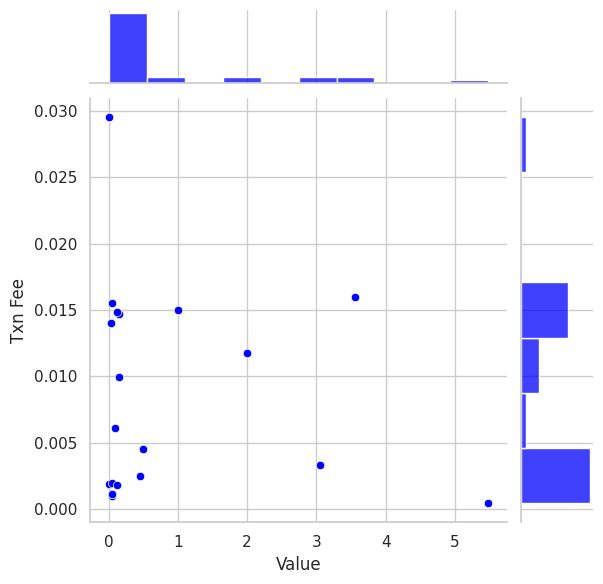

In [30]:
sns.set_theme(style="whitegrid")
sns.jointplot(x="Value", y="Txn Fee", data=danger_df, kind="scatter", color = "Blue")
plt.show()

## Data Sampling and Analysis

In this section, we will delve into the process of data sampling and perform an initial analysis on the transaction data we have collected. Our objective is to understand the distribution of transaction values by sampling the data and comparing the sample statistics with the population statistics.

### Steps

1. **Load the Data**: Import the collected transaction data into a pandas DataFrame.

2. **Data Cleaning**: Clean the data by handling missing values, converting data types, and removing any irrelevant information.

3. **Simple Random Sampling (SRS)**: Create a sample from the dataset using a simple random sampling method. This involves randomly selecting a subset of the data without regard to any specific characteristics of the data.

4. **Stratified Sampling**: Create another sample from the dataset using a stratified sampling method. This involves dividing the data into strata based on a specific characteristic (e.g., transaction value) and then randomly selecting samples from each stratum. Explain what you have stratified the data by and why you chose this column.

5. **Statistical Analysis**: Calculate the mean and standard deviation of the samples and the population. Compare these statistics to understand the distribution of transaction values.

6. **Visualization**: Plot the distribution of transaction values and fees for both the samples and the population to visually compare their distributions.

### Considerations

- **Sample Size**: The size of the sample should be large enough to represent the population accurately but not so large that it becomes impractical to analyze.
- **Sampling Method**: Choose the appropriate sampling method based on the characteristics of the data and the research question.

Explain the above considerations in your report.

We chose block number as the category of our subset also we chose 100 for our sample size. There are 10 blocks and by choosing 100 as our sample size we've taken around 10 transactions from each block and it's less than the 10% of our population size so the we can consider the chosen sample elements to be independent of each other. After plotting we can see that both stratified sampling and srs have similar distributions to our population so we can conclude that our sample can represent the population well.

/tmp/ipykernel_23896/825217431.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  strata = recent_blocks_df.groupby('Block Number', group_keys=False)


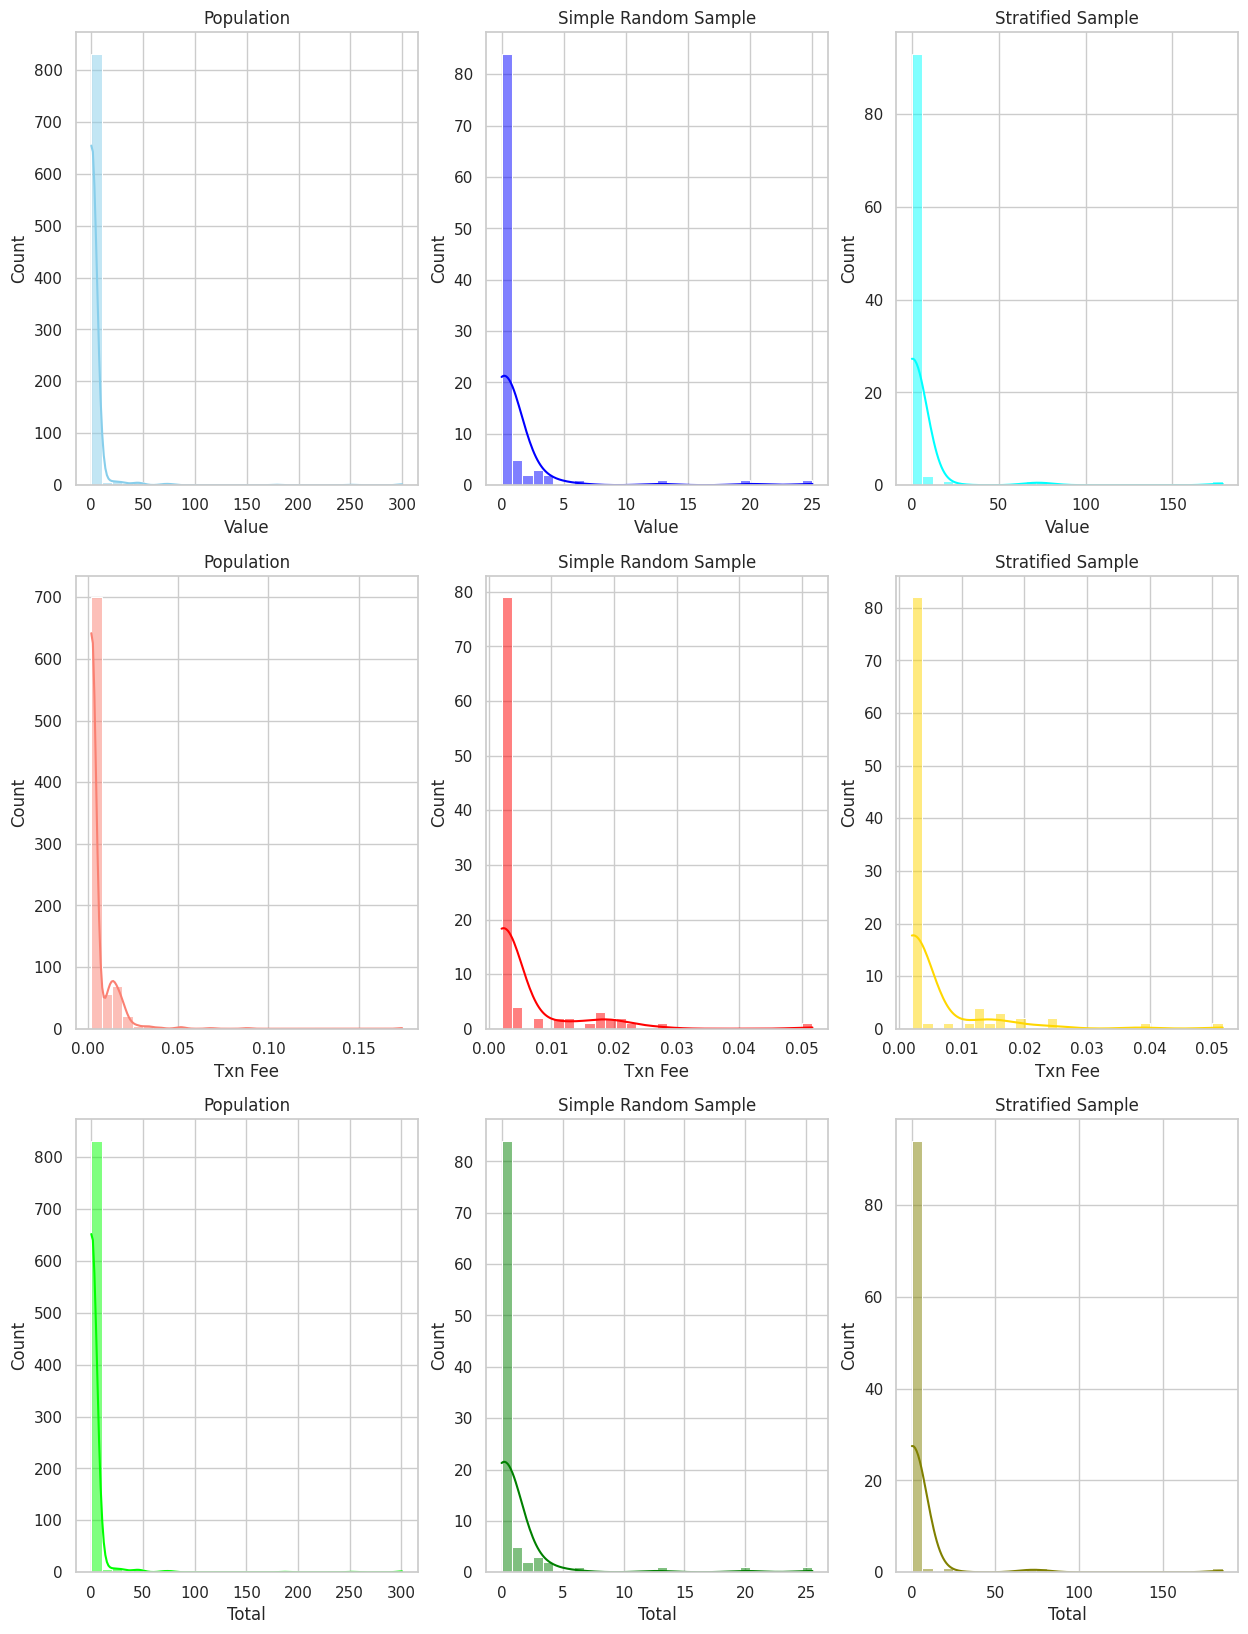

<Figure size 640x480 with 0 Axes>

In [31]:
# Simple Random Sampling (SRS)
# Sample size chosen as 100 for demonstration;
sample_size = 100
srs_sample = recent_blocks_df.sample(n=sample_size, random_state=42,replace=False)

# Stratified Sampling
recent_blocks_df['Block Number'] = recent_blocks_df['Block Number'].astype('category')
strata = recent_blocks_df.groupby('Block Number', group_keys=False)
# Apply proportional sampling within each stratum
stratified_sample = strata.apply(lambda x: x.sample(
    int(np.rint(sample_size*len(x)/len(recent_blocks_df))), random_state=42))

# Visualization
sns.set_theme(style="whitegrid")

datas = [recent_blocks_df, srs_sample, stratified_sample]
coulmns = ["Value", "Txn Fee", "Total"]
colors = ["skyblue", "blue", "cyan",
          "salmon", "red", "gold",
          "lime", "green", "olive"]
titles = ["Population", "Simple Random Sample", "Stratified Sample"]

plt.subplots(3, 3, figsize=(15, 20))

for i in range(len(colors)):
    plt.subplot(3, 3, i+1)
    sns.histplot(x=datas[i % 3][coulmns[i // 3]],
                 color=colors[i], bins=30, kde=True)
    plt.title(titles[i % 3])

plt.show()

plt.tight_layout()
plt.show()

/tmp/ipykernel_23896/3178467852.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  strata = random_blocks_df.groupby('Block Number', group_keys=False)


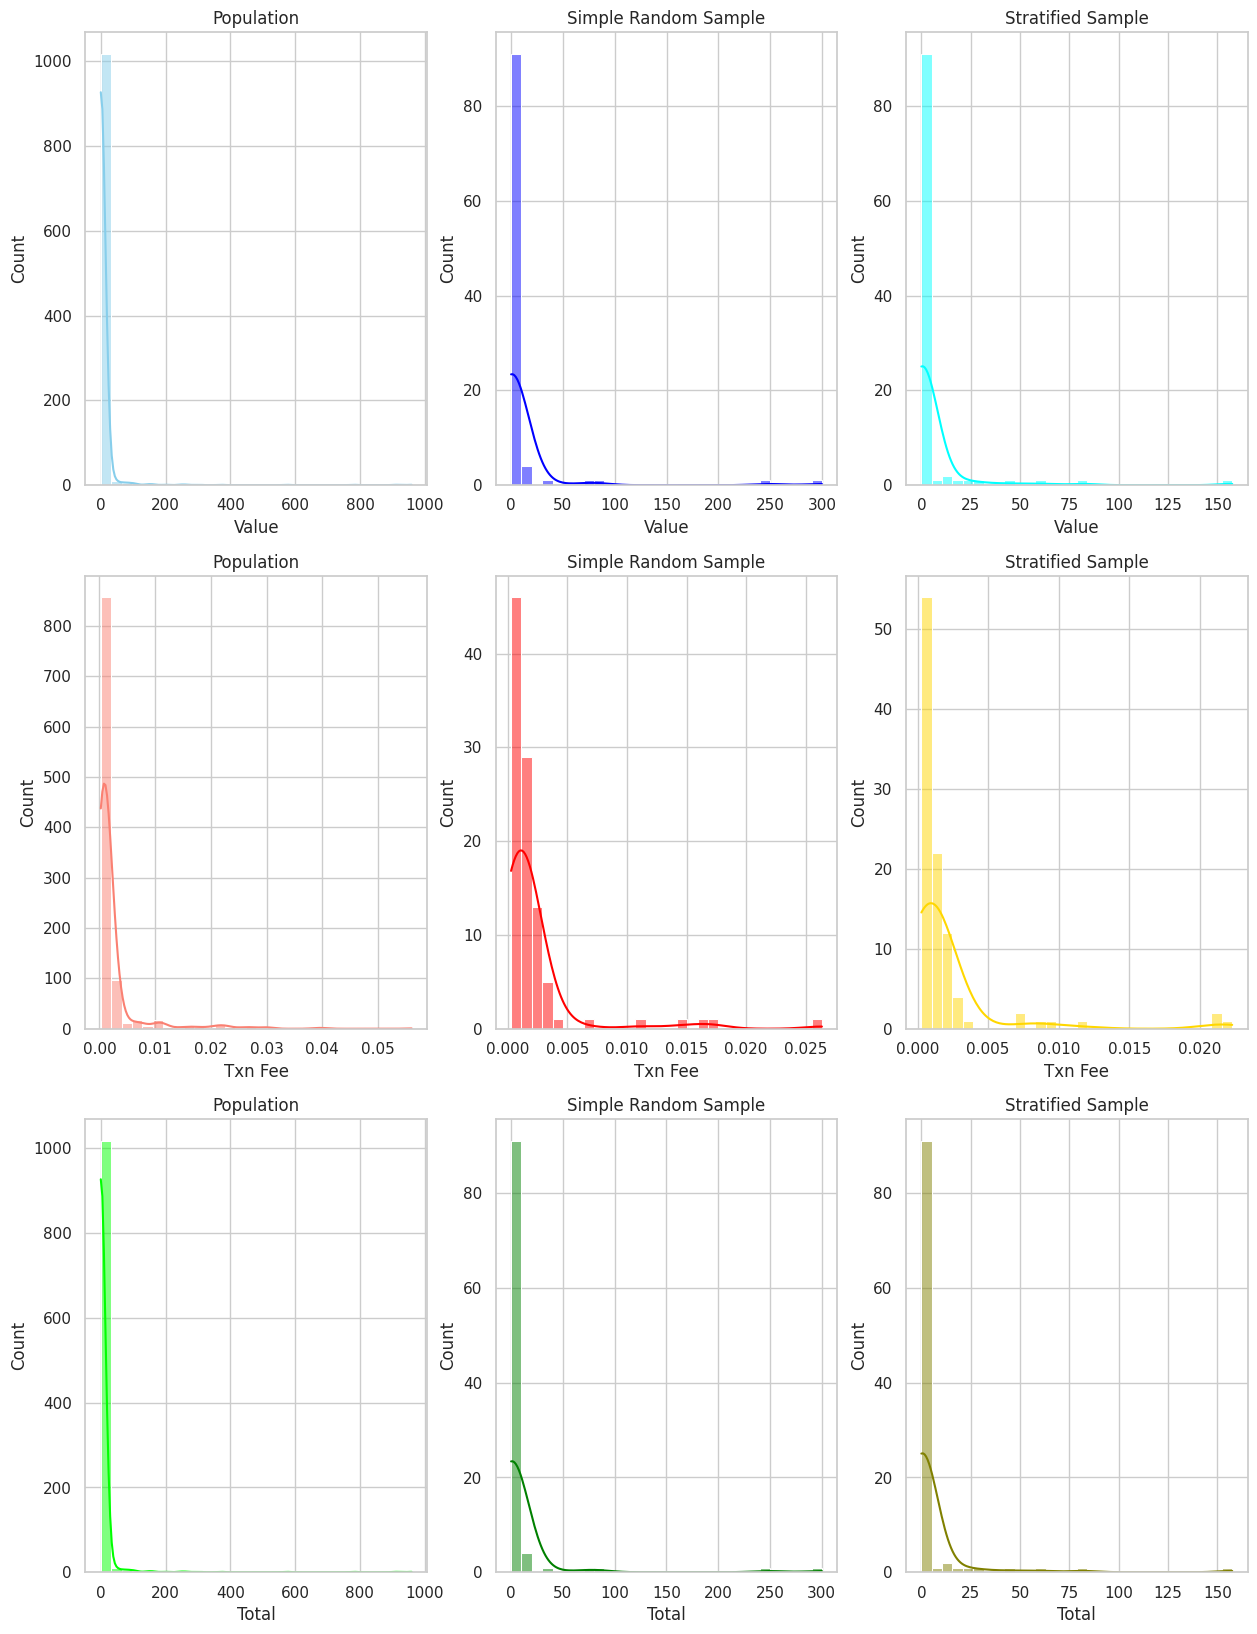

<Figure size 640x480 with 0 Axes>

In [32]:
# Simple Random Sampling (SRS)
# Sample size chosen as 100 for demonstration;
sample_size = 100
srs_sample = random_blocks_df.sample(n=sample_size, random_state=42, replace=False)

# Stratified Sampling
random_blocks_df['Block Number'] = random_blocks_df['Block Number'].astype(
    'category')
strata = random_blocks_df.groupby('Block Number', group_keys=False)
# Apply proportional sampling within each stratum
stratified_sample = strata.apply(lambda x: x.sample(
    int(np.rint(sample_size*len(x)/len(random_blocks_df))), random_state=42))

# Visualization
sns.set_theme(style="whitegrid")

datas = [random_blocks_df, srs_sample, stratified_sample]
coulmns = ["Value", "Txn Fee", "Total"]
colors = ["skyblue", "blue", "cyan",
          "salmon", "red", "gold",
          "lime", "green", "olive"]
titles = ["Population", "Simple Random Sample", "Stratified Sample"]

plt.subplots(3, 3, figsize=(15, 20))

for i in range(len(colors)):
    plt.subplot(3, 3, i+1)
    sns.histplot(x=datas[i % 3][coulmns[i // 3]],
                 color=colors[i], bins=30, kde=True)
    plt.title(titles[i % 3])

plt.show()

plt.tight_layout()
plt.show()

## Questions

1. What are some potential limitations when using web scraping for data collection?
Specifically, what problems did you face while fetching data from Etherscan? What
problems can these limitations cause in your analysis?

We needed to put delays after every get request so that the dynamic content would be loaded. Furthermore there were some older blocks that when we tried to access its page it wouold give us an error so we fixed this by skiping those blocks.

2. What can make your analysis untrustworthy? What are your solutions?

Missing data, zero value and other attacks, outliers, and transactions wih errors may make the analysis unworthy and we tried to decrease their effect by removing them though, we could replace them with some other value like mean, median, mode, ....

3. How did the visualization help you in understanding the data? What could you
interpret from the plots?

After observing the plots several questions came up like why isn't tax proportionally increasing with value or do values follow the normal distribution. Another observation was that most transaction values were very small and that makes sense due to how much 1 eth is today though, the fact that in random transactins from past there were much more transactions with smaller values may mean that there are more transactions with smaller value regardless how much the price of eth is.

4. How do the two sampling methods differ in their output? Compare these and explain
which one is a better fit to the population.

Both sampling methods represent the population very well and that means the data is distributed among the blocks uniformly and there isn't much difference in using these two methods if we choose blocks as our category for stratified sampling.